In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, get_frame, get_frame_test, get_info_from_seqinfo
from constants import TRAIN_PATH, TEST_PATH
from dataset import df_train, get_vid_img_path, get_vid_gt_path
from FasterRcnn.inference import *

from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ============== Models ============== 
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import supervision as sv # tracker 
# shut down loggings
import logging
logging.getLogger("ultralytics").setLevel(logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)

device

device(type='cuda')

In [2]:
image = get_frame("02", 1)

model  = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)
categories = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"]

In [3]:
results = inference(model, image, device)

In [4]:
box_annotator = sv.BoxAnnotator() # to draw boxes
label_annotator = sv.LabelAnnotator() # to draw ids on boxes
tracker = sv.ByteTrack() # to track IDs


In [5]:
boxes = results[0]["boxes"].cpu().numpy()
labels = results[0]["labels"].cpu().numpy()
confidence = results[0]["scores"].cpu().numpy()

mask = (labels == 1) & (confidence > 0.5)
boxes = boxes[mask]
labels = labels[mask]
confidence = confidence[mask]

detections = sv.Detections(
    xyxy=boxes, confidence=confidence, class_id=labels
)
detections = tracker.update_with_detections(detections)

labels = [
        f"#{tracker_id} {categories[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]
# detections = tracker.update_with_detections(detections) # to keep tracking of Ids

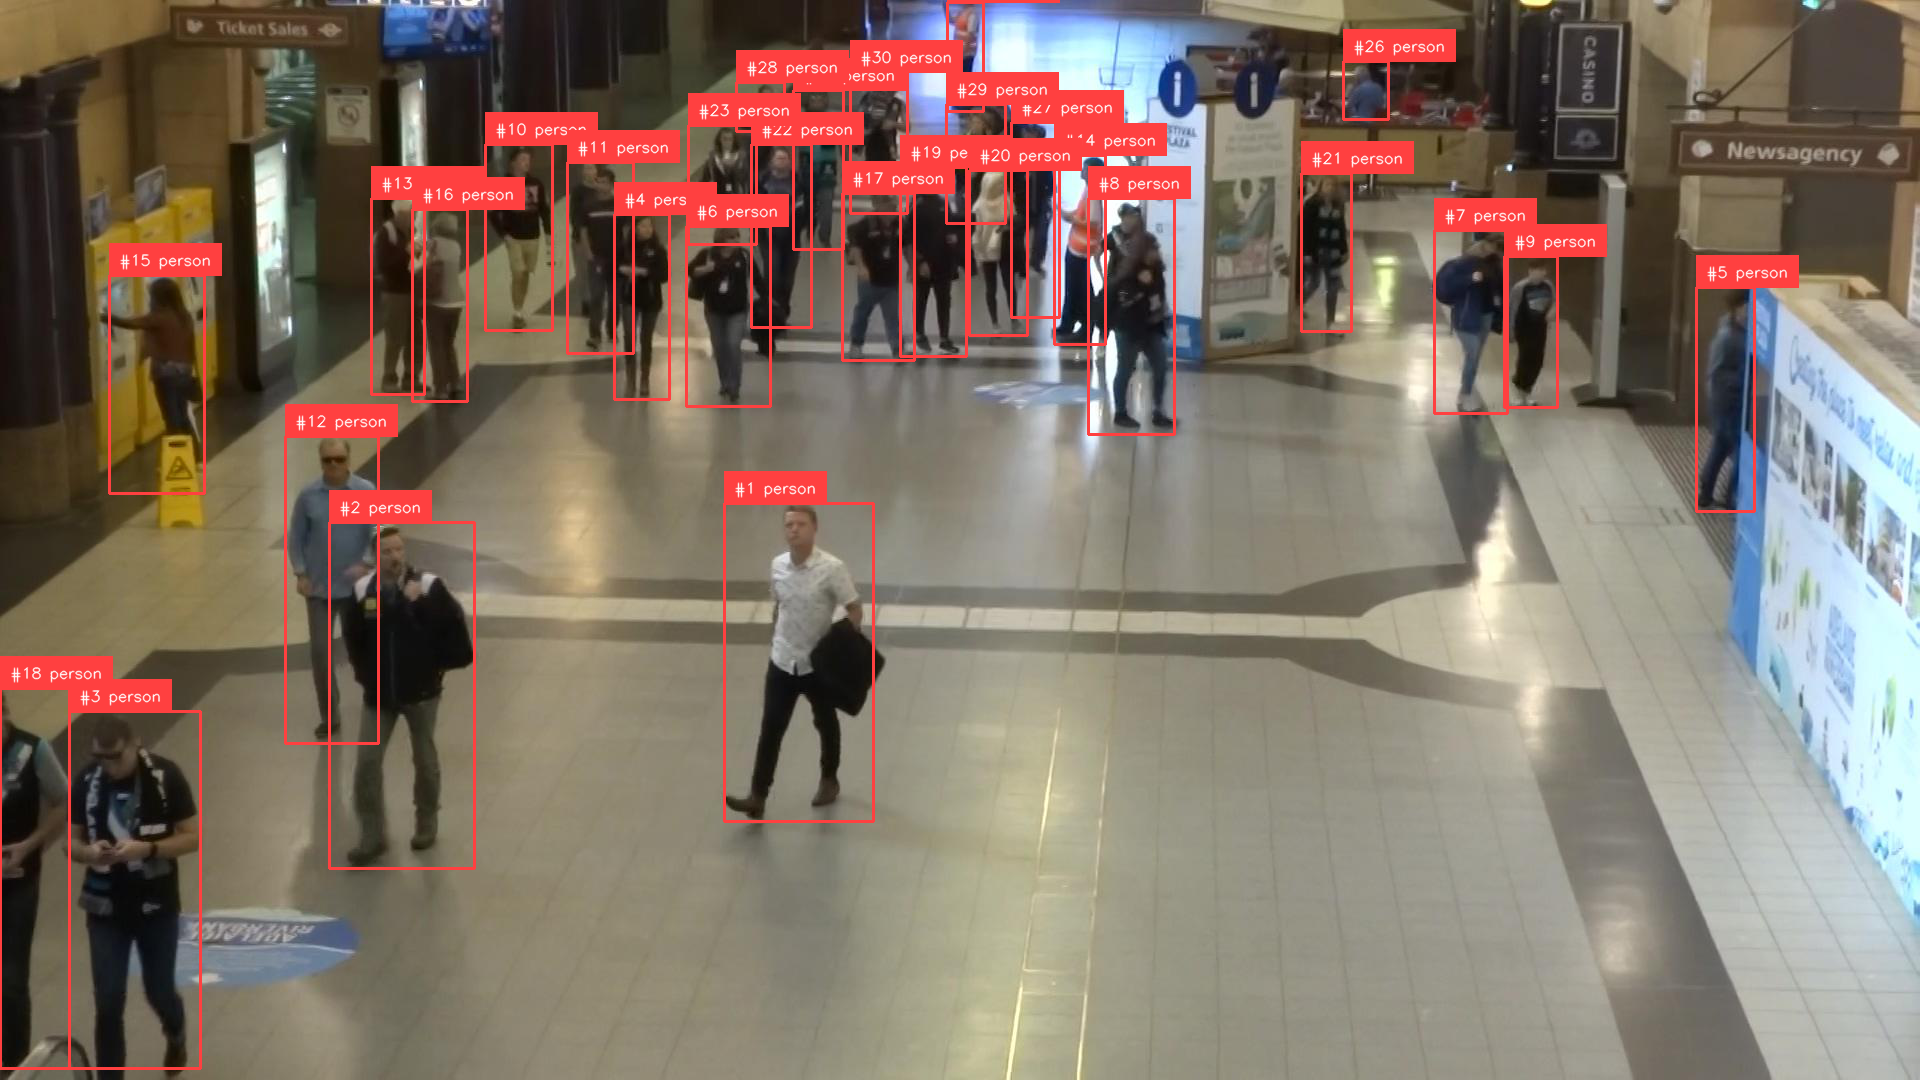

In [6]:
annotated_frame = box_annotator.annotate(image.copy(), detections=detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)

annotated_frame